In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Data quality check and cleaning
*By Jackson Baker*

- Our original plan was to examine this dataset from a classification perspective and attempt to determine whether or not a certain movie would be likely to win an Oscar, so we turned many of the Oscar related columns in our dataset to numeric 1s and 0s rather than the categorical "Yes" or "No' options that were already present.

In [2]:
movies = pd.read_csv('movies.csv')

In [3]:
# Changing some binary string columns to binary numeric
movies.loc[movies.Oscar_Best_Picture_won == 'Yes', 'Oscar_Best_Picture_won'] = 1
movies.loc[movies.Oscar_Best_Picture_won == 'No', 'Oscar_Best_Picture_won'] = 0
movies.loc[movies.Oscar_Best_Picture_nominated == 'Yes', 'Oscar_Best_Picture_nominated'] = 1
movies.loc[movies.Oscar_Best_Picture_nominated == 'No', 'Oscar_Best_Picture_nominated'] = 0

In [4]:
# There were many columns that existed in the data as strings of numbers so we made certain that all of the following columns were 
# numeric in nature before proceeding.
movies['metascore'] = pd.to_numeric(movies['metascore'])
movies['month'] = pd.to_numeric(movies['release_date.month'])
movies['votes'] = pd.to_numeric(movies['votes'])
movies['gross'] = pd.to_numeric(movies['gross'])
movies['Golden_Globes_nominated'] = pd.to_numeric(movies['Golden_Globes_nominated'])
movies['BAFTA_nominated'] = pd.to_numeric(movies['BAFTA_nominated'])
movies['Oscar_Best_Picture_won'] = pd.to_numeric(movies['Oscar_Best_Picture_won'])
movies['Oscar_Best_Picture_nominated'] = pd.to_numeric(movies['Oscar_Best_Picture_nominated'])

In [5]:
# Getting the columns that were most relevant and important to our analysis
movies_new = movies[['year', 'movie', 'certificate', 'genre', 'duration', 'rate', 'metascore', 'votes', 'gross', 
                   'release_date', 'user_reviews', 'critic_reviews', 'popularity', 'awards_wins', 'awards_nominations',
                   'Oscar_nominated', 'month']]

# Removing entries in the certificate column that were irrelevant to our inference goals
new_movies_new = movies_new.loc[movies['certificate'] != 'Not Rated']
new_movies_new = new_movies_new.loc[movies['certificate'] != 'TV-MA']

<AxesSubplot:xlabel='votes', ylabel='Density'>

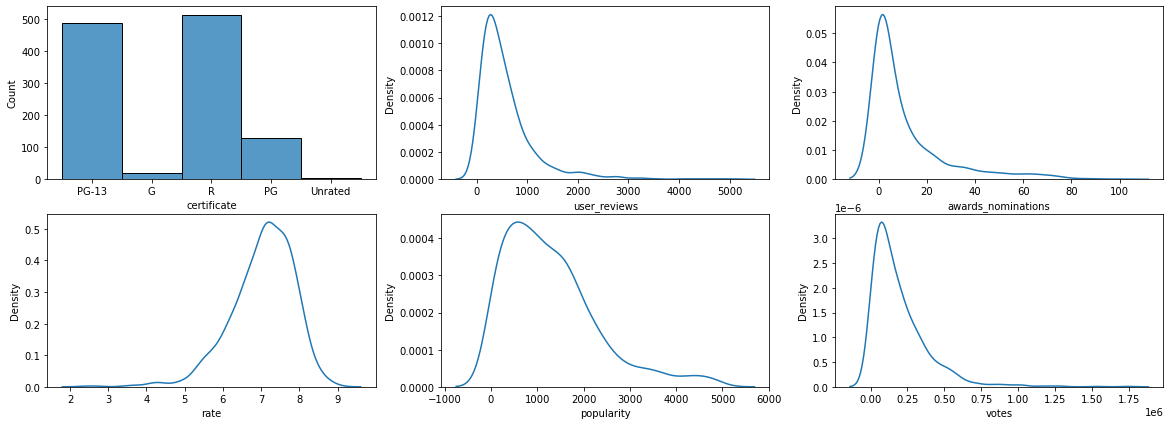

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,7))

sns.histplot(ax = axs[0, 0], data = new_movies_new, x = 'certificate')
sns.kdeplot(ax = axs[1, 0], data = new_movies_new, x = 'rate')
sns.kdeplot(ax = axs[0, 1], data = new_movies_new, x = 'user_reviews')
sns.kdeplot(ax = axs[1, 1], data = new_movies_new, x = 'popularity')
sns.kdeplot(ax = axs[0, 2], data = new_movies_new, x = 'awards_nominations')
sns.kdeplot(ax = axs[1, 2], data = new_movies_new, x = 'votes')

In [7]:
# Filling in NA values in some of the categories for use in the development of the model
pop_mean=new_movies_new['popularity'].mean()
new_movies_new['popularity'].fillna(value=pop_mean, inplace=True)

dur_mean=new_movies_new['duration'].mean()
new_movies_new['duration'].fillna(value=dur_mean, inplace=True)

rate_mean=new_movies_new['rate'].mean()
new_movies_new['rate'].fillna(value=rate_mean, inplace=True)

rev_mean=new_movies_new['user_reviews'].mean()
new_movies_new['user_reviews'].fillna(value=rev_mean, inplace=True)

### Data preparation
*By Jackson Baker*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. We needed to split our data into a test and train data set and settled on a 60% train and 40% test split to use for our model development. 

2. We binned the awards_nominations column because many movies had very few nominations and only a few had money. We wanted to ensure that adequate weight was given to movies that won many awards.

In [8]:
# Splitting data into a train and test data set
np.random.seed(2)
train = new_movies_new.sample(round(movies_new.shape[0]*0.6))
test = new_movies_new.drop(train.index)

In [9]:
# Binning awards_nominations for both train and test datasets
train['award_noms_binned'] = pd.cut(train['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])
test['award_noms_binned'] = pd.cut(test['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])


### Exploratory data analysis
By Jackson Baker

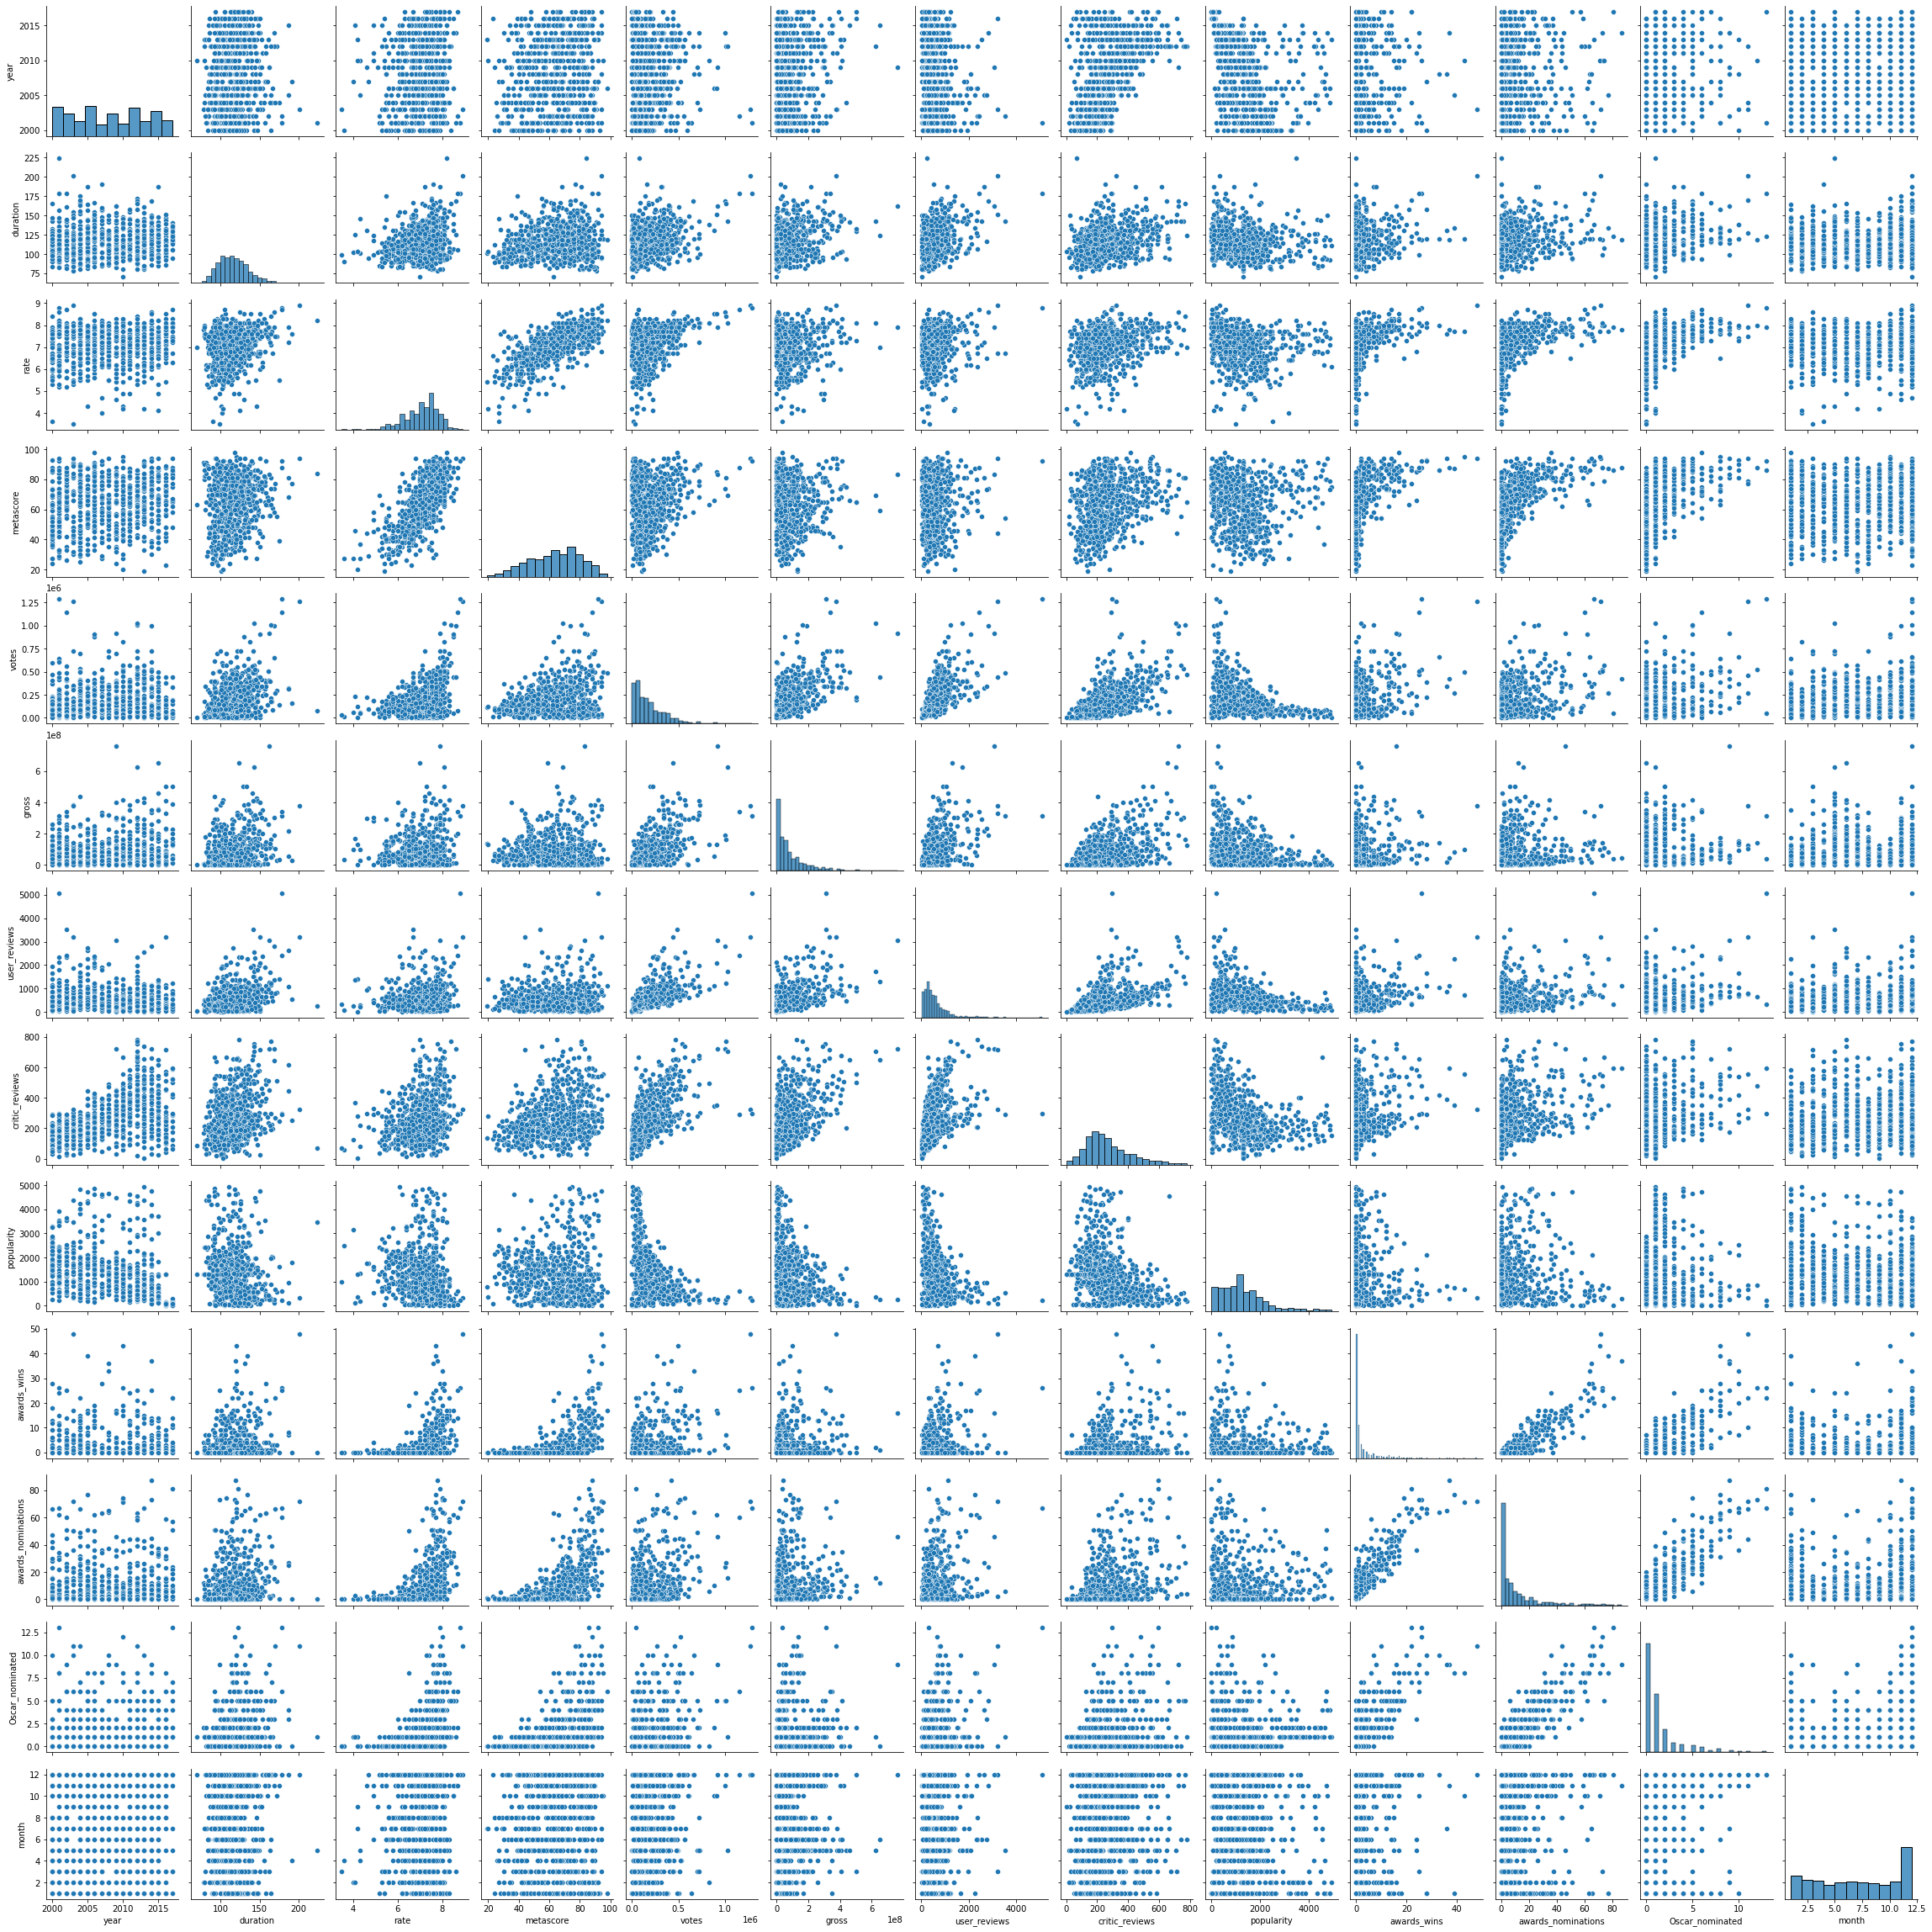

In [10]:
sns.pairplot(train)

In [11]:
# Correlation matrix to examine relationships with the target variable as well as prepare for potential multicollinearity concerns later 
new_movies_new.corr()

year  duration      rate  metascore     votes  \
year                1.000000  0.061827  0.110095   0.143086 -0.013431   
duration            0.061827  1.000000  0.293355   0.164420  0.343586   
rate                0.110095  0.293355  1.000000   0.718046  0.396899   
metascore           0.143086  0.164420  0.718046   1.000000  0.191527   
votes              -0.013431  0.343586  0.396899   0.191527  1.000000   
gross               0.101932  0.258685  0.080083   0.018431  0.604454   
user_reviews       -0.165258  0.373166  0.176443   0.073129  0.727661   
critic_reviews      0.510692  0.293200  0.309725   0.319501  0.594040   
popularity         -0.350531 -0.167574 -0.150442  -0.008611 -0.362952   
awards_wins         0.057264  0.202572  0.399772   0.495855  0.362241   
awards_nominations  0.106837  0.255619  0.483175   0.586907  0.349058   
Oscar_nominated     0.055988  0.310108  0.440858   0.504390  0.299225   
month               0.054556  0.096498  0.029348   0.018394  0.071852   

                       gross  user_reviews  critic_reviews  popularity  \
year                0.101932     -0.165258        0.510692   -0.350531   
duration            0.258685      0.373166        0.293200   -0.167574   
rate                0.080083      0.176443        0.309725   -0.150442   
metascore           0.018431      0.073129        0.319501   -0.008611   
votes               0.604454      0.727661        0.594040   -0.362952   
gross               1.000000      0.580119        0.470776   -0.291918   
user_reviews        0.580119      1.000000        0.468631   -0.283762   
critic_reviews      0.470776      0.468631        1.000000   -0.339458   
popularity         -0.291918     -0.283762       -0.339458    1.000000   
awards_wins         0.122324      0.291086        0.359746   -0.128351   
awards_nominations  0.107460      0.278847        0.426868   -0.116637   
Oscar_nominated     0.124091      0.258203        0.320785   -0.067159   
month               0.108830      0.061109        0.074377   -0.074744   

                    awards_wins  awards_nominations  Oscar_nominated     month  
year                   0.057264            0.106837         0.055988  0.054556  
duration               0.202572            0.255619         0.310108  0.096498  
rate                   0.399772            0.483175         0.440858  0.029348  
metascore              0.495855            0.586907         0.504390  0.018394  
votes                  0.362241            0.349058         0.299225  0.071852  
gross                  0.122324            0.107460         0.124091  0.108830  
user_reviews           0.291086            0.278847         0.258203  0.061109  
critic_reviews         0.359746            0.426868         0.320785  0.074377  
popularity            -0.128351           -0.116637        -0.067159 -0.074744  
awards_wins            1.000000            0.876319         0.773203  0.069124  
awards_nominations     0.876319            1.000000         0.871885  0.105860  
Oscar_nominated        0.773203            0.871885         1.000000  0.113459  
month                  0.069124            0.105860         0.113459  1.000000

<AxesSubplot:xlabel='votes', ylabel='gross'>

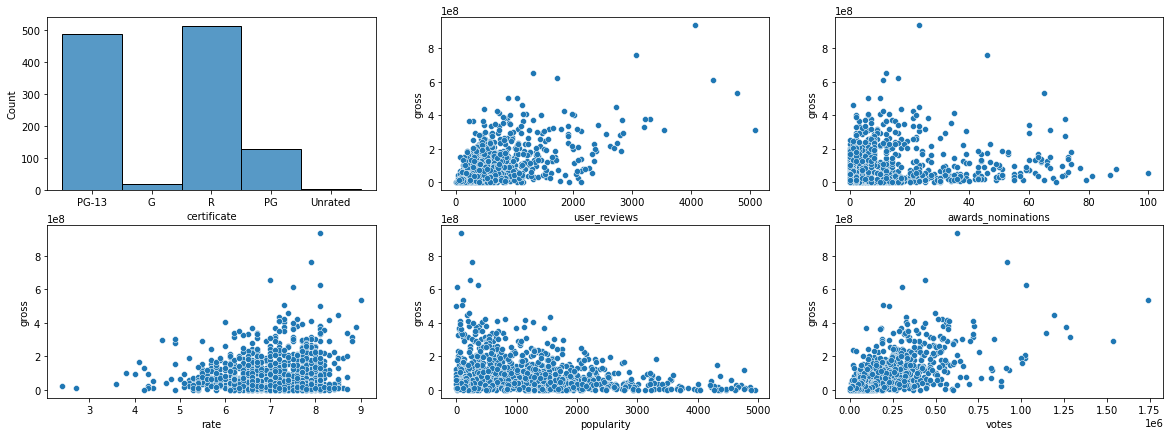

In [12]:
# Picking out a couple of the predictors we wanted to take a closer look at and examining their relationship with our target variable
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,7))

sns.histplot(ax = axs[0, 0], data = new_movies_new, x = 'certificate')

sns.scatterplot(ax = axs[1, 0], data = new_movies_new, x = 'rate', y = 'gross')

sns.scatterplot(ax = axs[0, 1], data = new_movies_new, x = 'user_reviews', y = 'gross')

sns.scatterplot(ax = axs[1, 1], data = new_movies_new, x = 'popularity', y = 'gross')

sns.scatterplot(ax = axs[0, 2], data = new_movies_new, x = 'awards_nominations', y = 'gross')

sns.scatterplot(ax = axs[1, 2], data = new_movies_new, x = 'votes', y = 'gross')

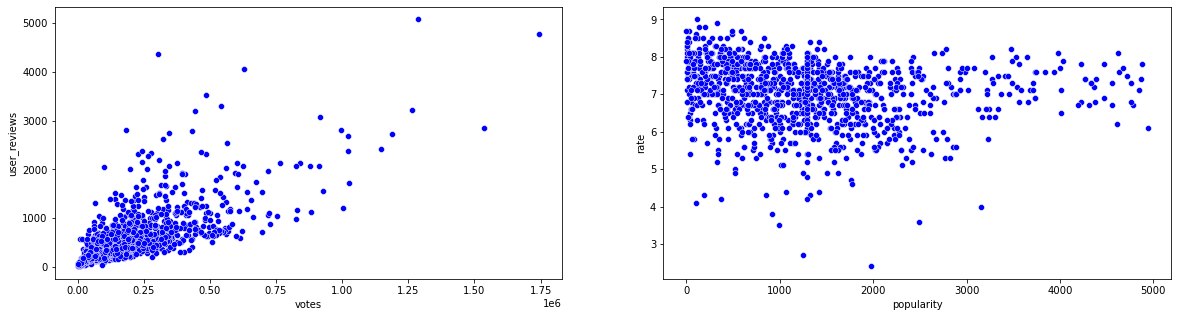

In [13]:
# Examining potential relationships or interactions between predictors that we're considering using
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.scatterplot(ax = axs[0], x = new_movies_new.votes, y=new_movies_new.user_reviews, color = 'blue')
sns.scatterplot(ax = axs[1], x = new_movies_new.popularity, y=new_movies_new.rate, color = 'blue')

plt.show()

### Model Implementation
By Tanya Venkatesh

In [14]:
# Model - using votes, user_reviews, rate, certificate, binned awards_nominations
ols_object = smf.ols(formula = 'gross ~ votes * user_reviews + np.exp(rate) + certificate + np.log(popularity) + award_noms_binned', data = train)
og_model = ols_object.fit()
print(og_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     78.11
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          4.62e-119
Time:                        11:37:34   Log-Likelihood:                -13394.
No. Observations:                 690   AIC:                         2.681e+04
Df Residuals:                     677   BIC:                         2.687e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [15]:
pred_gross = og_model.predict(test)
print('RMSE of original model:', np.sqrt(((test['gross'] - pred_gross)**2).mean()))

# Calculating RSE:
print("RSE of original model: ", np.sqrt(og_model.mse_resid))

RMSE of original model: 67377854.35241388
RSE of original model:  65830753.88123619


In [16]:
# FINDING THE MODEL WITHOUT LEVERAGE POINTS

# Finding outliers and leverage points
#Studentized residuals
out = og_model.outlier_test()

#Computing the leverage statistic for each observation
influence = og_model.get_influence()
leverage = influence.hat_matrix_diag

#Average leverage of points
average_leverage = (og_model.df_model+1)/og_model.nobs

#Number of high leverage points in the dataset
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

#Dropping influential points from data
influential_index = out.loc[(np.abs(out.student_resid) > 3) & (leverage > high_leverage_threshold), :].index
train_filtered2 = train.drop(influential_index)

/Users/jacksonbaker/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [17]:
ols_object = smf.ols(formula = 'gross ~ votes * user_reviews + np.exp(rate) + certificate + np.log(popularity) + award_noms_binned', data = train_filtered2)
model_filt = ols_object.fit()
print(model_filt.summary())

pred_gross = model_filt.predict(test)
print('RMSE of Model without leverage points:', np.sqrt(((test['gross'] - pred_gross)**2).mean()))

# Calculating RSE:
print("RSE of Model without leverage points: ", np.sqrt(model_filt.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     77.61
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          2.42e-118
Time:                        11:37:35   Log-Likelihood:                -13308.
No. Observations:                 687   AIC:                         2.664e+04
Df Residuals:                     674   BIC:                         2.670e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [18]:
pred_gross = model_filt.predict(test)
rmse_filt = (np.sqrt(((test['gross'] - pred_gross)**2).mean()))
rmse_filt

67456964.15969072

### Residual Plotting
By Jackson Baker

Text(0, 0.5, 'Residuals')

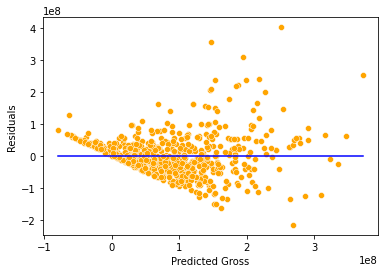

In [19]:
# Plotting the residuals to evaluate aspects of the model and model assumptions

sns.scatterplot(x = model_filt.fittedvalues, y=model_filt.resid, color = 'orange')
sns.lineplot(x = [model_filt.fittedvalues.min(), model_filt.fittedvalues.max()], y = [0,0],color = 'blue')
plt.xlabel('Predicted Gross')
plt.ylabel('Residuals')

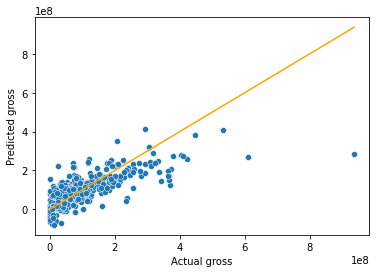

In [20]:
# Plotting predicted gross against real gross to see how close to y=x they are.

sns.scatterplot(x = test.gross, y = pred_gross)
sns.lineplot(x = [0, test.gross.max()], y = [0, test.gross.max()], color = 'orange')
plt.xlabel('Actual gross')
plt.ylabel('Predicted gross')
# Ideally, all points should fall on or close to y = x
plt.show()

### Developing the Model
By Maddie Banich

In [21]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [22]:
train.isna().sum()
t = train.dropna()

In [23]:
vif_columns = t[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

In [24]:
vif_columns = add_constant(vif_columns)
vif_data = pd.DataFrame()
vif_data['predictor'] = vif_columns.columns
vif_data

predictor
0                const
1             duration
2                 rate
3            metascore
4                votes
5         user_reviews
6       critic_reviews
7           popularity
8          awards_wins
9   awards_nominations
10               month

In [25]:
for i in range(len(vif_columns.columns)):
    vif_data.loc[i, 'VIF'] = variance_inflation_factor(vif_columns.values, i)

vif_data

predictor         VIF
0                const  150.507257
1             duration    1.308338
2                 rate    2.536925
3            metascore    2.673174
4                votes    3.157512
5         user_reviews    2.271537
6       critic_reviews    1.846787
7           popularity    1.331156
8          awards_wins    4.987132
9   awards_nominations    5.822009
10               month    1.037708

In [26]:
# SUBSET SELECTION
import itertools
import time
import statsmodels.formula.api as sm

In [27]:
# trying forward stepwise
X = train[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

X_backup = train[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

In [28]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('gross~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def forward(predictors):

    # Pull out predictors we still need to process (remaining predictor)
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p])) # adding the remaining predictors one by one to the model
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [29]:
models_best = forward_selection()

Processed  10 models on 1 predictors in 0.050704002380371094 seconds.
Processed  9 models on 2 predictors in 0.03559303283691406 seconds.
Processed  8 models on 3 predictors in 0.03589892387390137 seconds.
Processed  7 models on 4 predictors in 0.03723502159118652 seconds.
Processed  6 models on 5 predictors in 0.03804802894592285 seconds.
Processed  5 models on 6 predictors in 0.0382080078125 seconds.
Processed  4 models on 7 predictors in 0.032711029052734375 seconds.
Processed  3 models on 8 predictors in 0.02483081817626953 seconds.
Processed  2 models on 9 predictors in 0.017531156539916992 seconds.
Processed  1 models on 10 predictors in 0.010865211486816406 seconds.
Total elapsed time: 0.3357360363006592 seconds.


In [30]:
models_best

Rsquared                                              model
1   0.383667  <statsmodels.regression.linear_model.Regressio...
2   0.428223  <statsmodels.regression.linear_model.Regressio...
3   0.454886  <statsmodels.regression.linear_model.Regressio...
4   0.459487  <statsmodels.regression.linear_model.Regressio...
5   0.464948  <statsmodels.regression.linear_model.Regressio...
6   0.468508  <statsmodels.regression.linear_model.Regressio...
7   0.469835  <statsmodels.regression.linear_model.Regressio...
8   0.469954  <statsmodels.regression.linear_model.Regressio...
9   0.469956  <statsmodels.regression.linear_model.Regressio...
10  0.469555  <statsmodels.regression.linear_model.Regressio...

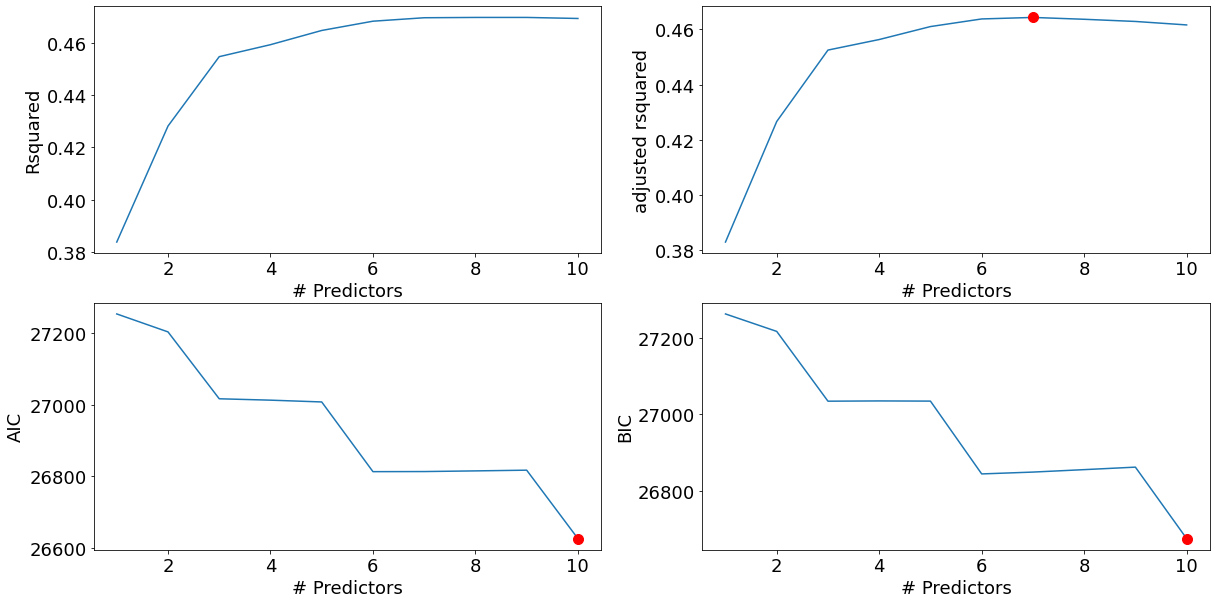

In [31]:
best_sub_plots()

In [32]:
best_fwd_model = models_best.loc[10,'model']
best_fwd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     59.31
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           1.51e-85
Time:                        11:37:35   Log-Likelihood:                -13302.
No. Observations:                 681   AIC:                         2.663e+04
Df Residuals:                     670   BIC:                         2.668e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.544e+08   3.48e+07      4.433      0.000     8.6e+07    2.23e+08
votes                294.7718     27.734     10.629      0.000     240.316     349.227
rate               -3.129e+07    5.7e+06     -5.493      0.000   -4.25e+07   -2.01e+07
critic_reviews      1.316e+05   2.69e+04      4.891      0.000    7.88e+04    1.84e+05
user_reviews        1.924e+04   8014.736      2.401      0.017    3505.032     3.5e+04
awards_nominations  -7.37e+05   4.47e+05     -1.650      0.099   -1.61e+06     1.4e+05
month               8.933e+05    7.8e+05      1.145      0.253   -6.39e+05    2.43e+06
duration             2.27e+05   1.63e+05      1.393      0.164    -9.3e+04    5.47e+05
popularity         -1997.2602   3305.617     -0.604      0.546   -8487.876    4493.355
awards_wins        -7315.4768   1.05e+06     -0.007      0.994   -2.08e+06    2.06e+06
metascore           3.877e+05   2.78e+05      1.396      0.163   -1.57e+05    9.33e+05
==============================================================================
Omnibus:                      237.650   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.378
Skew:                           1.487   Prob(JB):                    3.66e-266
Kurtosis:                       8.851   Cond. No.                     3.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# with fwd
pred_gross = best_fwd_model.predict(test)
rmse_fwd_noint = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_fwd_noint

75989332.93869507

In [34]:
# with all
all_model = sm.ols('gross~' + '+'.join(X.columns),data = train).fit()
pred_gross = all_model.predict(test)
rmse_all = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_all

75989332.93869787

In [35]:
# best subset w/o interactions

In [36]:
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k): # all subsets of k are evaluated
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()] # pickingthe best model among subsets w size k using R2
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [37]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])


# using a for loop to loop through and get best model for 1, 2, 3...k predictors
tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 10 models on 1 predictors in 0.03479194641113281 seconds.
Processed 45 models on 2 predictors in 0.17049384117126465 seconds.
Processed 120 models on 3 predictors in 0.6237430572509766 seconds.
Processed 210 models on 4 predictors in 1.2743358612060547 seconds.
Processed 252 models on 5 predictors in 1.579211950302124 seconds.
Processed 210 models on 6 predictors in 1.505180835723877 seconds.
Processed 120 models on 7 predictors in 0.8613529205322266 seconds.
Processed 45 models on 8 predictors in 0.27947378158569336 seconds.
Processed 10 models on 9 predictors in 0.06682205200195312 seconds.
Processed 1 models on 10 predictors in 0.009086847305297852 seconds.
Total elapsed time: 6.425538063049316 seconds.


In [38]:
models_best

Rsquared                                              model
1   0.383667  <statsmodels.regression.linear_model.Regressio...
2   0.428223  <statsmodels.regression.linear_model.Regressio...
3   0.454886  <statsmodels.regression.linear_model.Regressio...
4   0.459487  <statsmodels.regression.linear_model.Regressio...
5   0.464948  <statsmodels.regression.linear_model.Regressio...
6   0.468508  <statsmodels.regression.linear_model.Regressio...
7   0.469835  <statsmodels.regression.linear_model.Regressio...
8   0.469954  <statsmodels.regression.linear_model.Regressio...
9   0.469956  <statsmodels.regression.linear_model.Regressio...
10  0.469555  <statsmodels.regression.linear_model.Regressio...

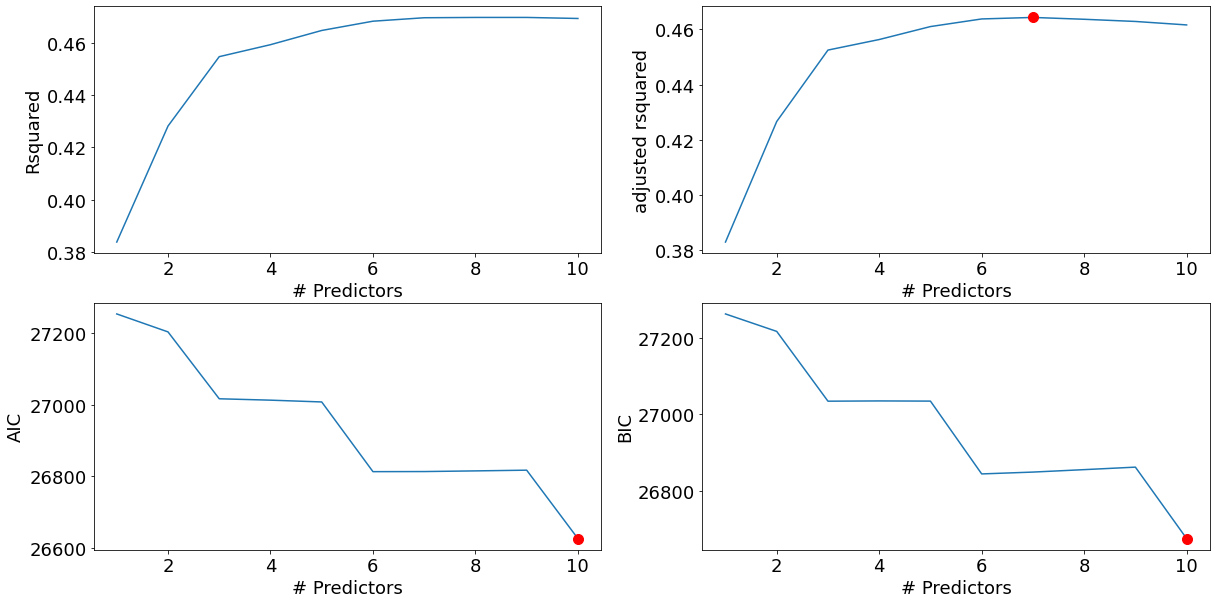

In [39]:
best_sub_plots()

In [40]:
best_subset_model = models_best.loc[10,'model']
best_subset_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     59.31
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           1.51e-85
Time:                        11:37:42   Log-Likelihood:                -13302.
No. Observations:                 681   AIC:                         2.663e+04
Df Residuals:                     670   BIC:                         2.668e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.544e+08   3.48e+07      4.433      0.000     8.6e+07    2.23e+08
duration             2.27e+05   1.63e+05      1.393      0.164    -9.3e+04    5.47e+05
rate               -3.129e+07    5.7e+06     -5.493      0.000   -4.25e+07   -2.01e+07
metascore           3.877e+05   2.78e+05      1.396      0.163   -1.57e+05    9.33e+05
votes                294.7718     27.734     10.629      0.000     240.316     349.227
user_reviews        1.924e+04   8014.736      2.401      0.017    3505.032     3.5e+04
critic_reviews      1.316e+05   2.69e+04      4.891      0.000    7.88e+04    1.84e+05
popularity         -1997.2602   3305.617     -0.604      0.546   -8487.876    4493.355
awards_wins        -7315.4768   1.05e+06     -0.007      0.994   -2.08e+06    2.06e+06
awards_nominations  -7.37e+05   4.47e+05     -1.650      0.099   -1.61e+06     1.4e+05
month               8.933e+05    7.8e+05      1.145      0.253   -6.39e+05    2.43e+06
==============================================================================
Omnibus:                      237.650   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.378
Skew:                           1.487   Prob(JB):                    3.66e-266
Kurtosis:                       8.851   Cond. No.                     3.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# with subset
pred_gross = best_subset_model.predict(test)
rmse_subset_noint = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_subset_noint

75989332.93869787

In [42]:
# fwd with interactions

In [43]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [44]:
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

/var/folders/qg/hcxcfnjx4ylc5wgsm8028_5h0000gn/T/ipykernel_93140/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/qg/hcxcfnjx4ylc5wgsm8028_5h0000gn/T/ipykernel_93140/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/qg/hcxcfnjx4ylc5wgsm8028_5h0000gn/T/ipykernel_93140/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [45]:
X.head()

duration  rate  metascore   votes  user_reviews  critic_reviews  \
357        109   6.8       63.0  159825        1057.0           277.0   
923        112   7.1       72.0  294558         854.0           544.0   
1019       101   5.4       19.0  111737         262.0           138.0   
1059       116   8.3       81.0  131024         709.0           514.0   
802        137   7.6       73.0   35248          78.0           227.0   

      popularity  awards_wins  awards_nominations  month  ...  \
357        836.0            0                   1    4.0  ...   
923       1308.0            1                   8    6.0  ...   
1019       787.0            0                   1    7.0  ...   
1059         4.0            6                  59   11.0  ...   
802       2934.0            0                   3    3.0  ...   

      critic_reviews_popularity  critic_reviews_awards_wins  \
357                    231572.0                         0.0   
923                    711552.0                       544.0   
1019                   108606.0                         0.0   
1059                     2056.0                      3084.0   
802                    666018.0                         0.0   

      critic_reviews_awards_nominations  critic_reviews_month  \
357                               277.0                1108.0   
923                              4352.0                3264.0   
1019                              138.0                 966.0   
1059                            30326.0                5654.0   
802                               681.0                 681.0   

      popularity_awards_wins  popularity_awards_nominations  popularity_month  \
357                      0.0                          836.0            3344.0   
923                   1308.0                        10464.0            7848.0   
1019                     0.0                          787.0            5509.0   
1059                    24.0                          236.0              44.0   
802                      0.0                         8802.0            8802.0   

      awards_wins_awards_nominations  awards_wins_month  \
357                                0                0.0   
923                                8                6.0   
1019                               0                0.0   
1059                             354               66.0   
802                                0                0.0   

      awards_nominations_month  
357                        4.0  
923                       48.0  
1019                       7.0  
1059                     649.0  
802                        9.0  

[5 rows x 55 columns]

In [46]:
models_best = forward_selection()

Processed  55 models on 1 predictors in 0.28063321113586426 seconds.
Processed  54 models on 2 predictors in 0.18584966659545898 seconds.
Processed  53 models on 3 predictors in 0.23259711265563965 seconds.
Processed  52 models on 4 predictors in 0.2563629150390625 seconds.
Processed  51 models on 5 predictors in 0.2894270420074463 seconds.
Processed  50 models on 6 predictors in 0.3188657760620117 seconds.
Processed  49 models on 7 predictors in 0.34151196479797363 seconds.
Processed  48 models on 8 predictors in 0.2980620861053467 seconds.
Processed  47 models on 9 predictors in 0.3180689811706543 seconds.
Processed  46 models on 10 predictors in 0.3384280204772949 seconds.
Processed  45 models on 11 predictors in 0.3551030158996582 seconds.
Processed  44 models on 12 predictors in 0.3680570125579834 seconds.
Processed  43 models on 13 predictors in 0.38239502906799316 seconds.
Processed  42 models on 14 predictors in 0.4565849304199219 seconds.
Processed  41 models on 15 predictors 

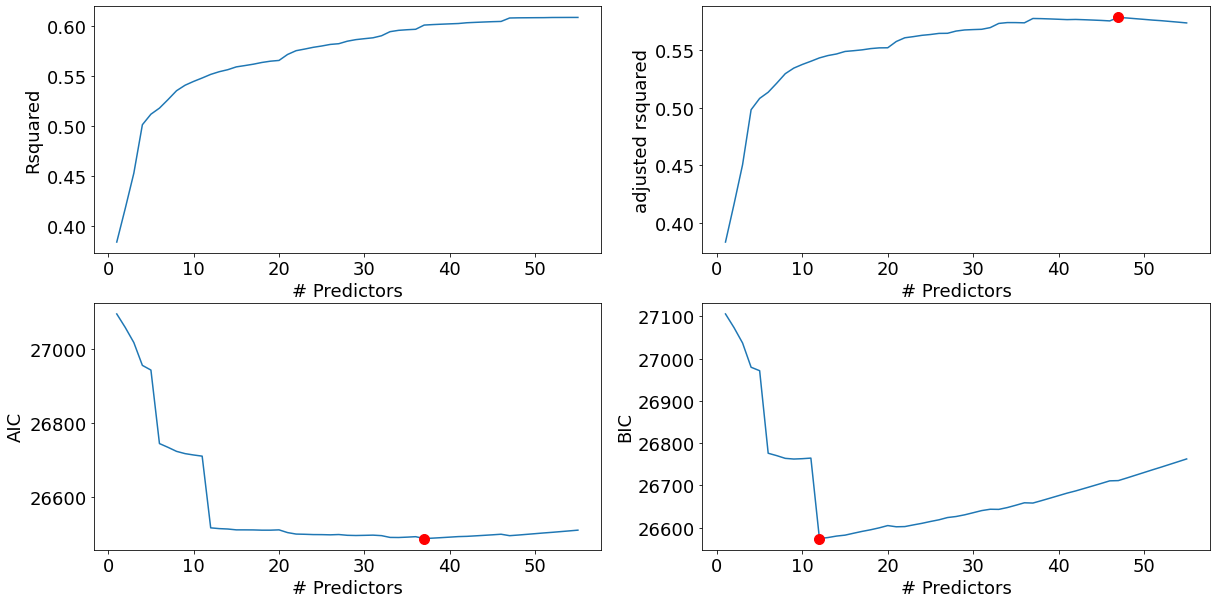

In [47]:
best_sub_plots()

In [48]:
best_fwd_inter_model = models_best.loc[46,'model']
best_fwd_inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     21.04
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           8.25e-99
Time:                        11:38:03   Log-Likelihood:                -13202.
No. Observations:                 681   AIC:                         2.650e+04
Df Residuals:                     634   BIC:                         2.671e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -6.213e+07   1.06e+08     -0.585      0.558   -2.71e+08    1.46e+08
votes_critic_reviews                  0.0019      0.177      0.011      0.991      -0.345       0.349
rate                                2.25e+07   2.38e+07      0.944      0.345   -2.43e+07    6.93e+07
votes                              1986.9290    341.876      5.812      0.000    1315.583    2658.275
rate_votes                         -341.9189     46.671     -7.326      0.000    -433.567    -250.271
duration_votes                        1.4596      1.332      1.095      0.274      -1.157       4.076
metascore_votes                       9.8589      2.248      4.386      0.000       5.445      14.273
awards_wins_awards_nominations    -1.227e+05   3.23e+04     -3.798      0.000   -1.86e+05   -5.92e+04
rate_awards_wins                   2.059e+06    2.7e+06      0.762      0.446   -3.25e+06    7.37e+06
duration_metascore                 9554.4092   1.37e+04      0.698      0.485   -1.73e+04    3.64e+04
critic_reviews_popularity          -102.8743     30.284     -3.397      0.001    -162.344     -43.404
user_reviews_awards_wins            296.6382   2921.602      0.102      0.919   -5440.549    6033.825
popularity_month                   -595.0209    730.957     -0.814      0.416   -2030.411     840.370
votes_popularity                      0.1332      0.049      2.738      0.006       0.038       0.229
duration_critic_reviews            -519.7522   1381.125     -0.376      0.707   -3231.886    2192.381
metascore_popularity                581.5554    278.626      2.087      0.037      34.415    1128.696
user_reviews_popularity             -19.9050     15.192     -1.310      0.191     -49.738       9.928
duration_user_reviews               374.9274    342.912      1.093      0.275    -298.454    1048.309
user_reviews                       9.771e+04   9.21e+04      1.061      0.289   -8.32e+04    2.79e+05
popularity_awards_nominations        35.3930    373.465      0.095      0.925    -697.984     768.770
rate_critic_reviews                2.085e+05   5.42e+04      3.846      0.000    1.02e+05    3.15e+05
critic_reviews                    -9.047e+05   3.41e+05     -2.656      0.008   -1.57e+06   -2.36e+05
metascore_critic_reviews          -5598.8342   2626.927     -2.131      0.033   -1.08e+04    -440.304
awards_wins                       -1.865e+07   2.16e+07     -0.864      0.388    -6.1e+07    2.37e+07
rate_user_reviews                 -2.315e+04   1.15e+04     -2.006      0.045   -4.58e+04    -486.137
votes_awards_wins                    11.0148      7.515      1.466      0.143      -3.742      25.772
critic_reviews_awards_wins        -1.425e+04   8972.890     -1.588      0.113   -3.19e+04    3368.087
votes_awards_nomination

In [49]:
pred_gross = best_fwd_inter_model.predict(test)
rmse_fwd_int = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_fwd_int

75749129.1169696

In [50]:
# backward w/ interactions
X.head()

duration  rate  metascore   votes  user_reviews  critic_reviews  \
357        109   6.8       63.0  159825        1057.0           277.0   
923        112   7.1       72.0  294558         854.0           544.0   
1019       101   5.4       19.0  111737         262.0           138.0   
1059       116   8.3       81.0  131024         709.0           514.0   
802        137   7.6       73.0   35248          78.0           227.0   

      popularity  awards_wins  awards_nominations  month  ...  \
357        836.0            0                   1    4.0  ...   
923       1308.0            1                   8    6.0  ...   
1019       787.0            0                   1    7.0  ...   
1059         4.0            6                  59   11.0  ...   
802       2934.0            0                   3    3.0  ...   

      critic_reviews_popularity  critic_reviews_awards_wins  \
357                    231572.0                         0.0   
923                    711552.0                       544.0   
1019                   108606.0                         0.0   
1059                     2056.0                      3084.0   
802                    666018.0                         0.0   

      critic_reviews_awards_nominations  critic_reviews_month  \
357                               277.0                1108.0   
923                              4352.0                3264.0   
1019                              138.0                 966.0   
1059                            30326.0                5654.0   
802                               681.0                 681.0   

      popularity_awards_wins  popularity_awards_nominations  popularity_month  \
357                      0.0                          836.0            3344.0   
923                   1308.0                        10464.0            7848.0   
1019                     0.0                          787.0            5509.0   
1059                    24.0                          236.0              44.0   
802                      0.0                         8802.0            8802.0   

      awards_wins_awards_nominations  awards_wins_month  \
357                                0                0.0   
923                                8                6.0   
1019                               0                0.0   
1059                             354               66.0   
802                                0                0.0   

      awards_nominations_month  
357                        4.0  
923                       48.0  
1019                       7.0  
1059                     649.0  
802                        9.0  

[5 rows x 55 columns]

In [51]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [52]:
models_best = backward_selection()

Processed  55 models on 54 predictors in 1.9315760135650635 seconds.
Processed  54 models on 53 predictors in 1.7611348628997803 seconds.
Processed  53 models on 52 predictors in 1.7276699542999268 seconds.
Processed  52 models on 51 predictors in 1.6220128536224365 seconds.
Processed  51 models on 50 predictors in 1.6825459003448486 seconds.
Processed  50 models on 49 predictors in 1.5152850151062012 seconds.
Processed  49 models on 48 predictors in 1.4373371601104736 seconds.
Processed  48 models on 47 predictors in 1.3755519390106201 seconds.
Processed  47 models on 46 predictors in 1.4220399856567383 seconds.
Processed  46 models on 45 predictors in 1.250265121459961 seconds.
Processed  45 models on 44 predictors in 1.202131986618042 seconds.
Processed  44 models on 43 predictors in 1.1368567943572998 seconds.
Processed  43 models on 42 predictors in 1.0960710048675537 seconds.
Processed  42 models on 41 predictors in 1.0794761180877686 seconds.
Processed  41 models on 40 predictor

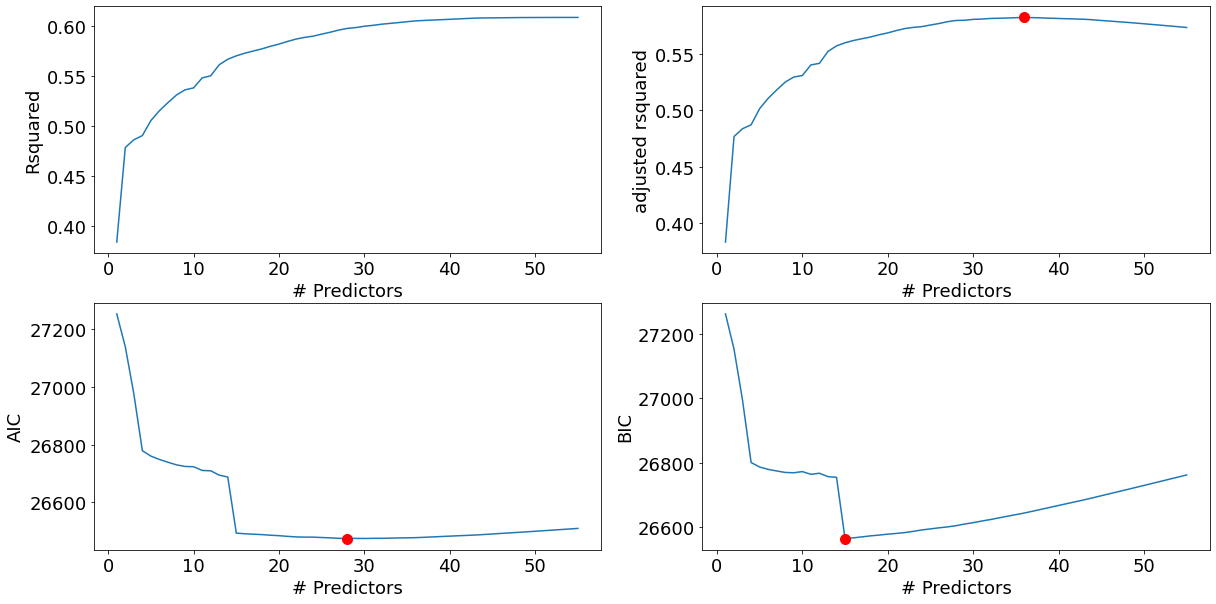

In [53]:
best_sub_plots()

In [54]:
best_bck_inter_model = models_best.loc[15,'model']
best_bck_inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     58.72
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          5.79e-111
Time:                        11:38:39   Log-Likelihood:                -13230.
No. Observations:                 681   AIC:                         2.649e+04
Df Residuals:                     665   BIC:                         2.657e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                      -3.241e+07   1.17e+07     -2.770      0.006   -5.54e+07   -9.43e+06
votes                           2598.9667    240.130     10.823      0.000    2127.462    3070.471
critic_reviews                 -9.292e+05   2.14e+05     -4.337      0.000   -1.35e+06   -5.09e+05
popularity                      7.493e+04   1.88e+04      3.983      0.000     3.8e+04    1.12e+05
awards_nominations              1.824e+07   3.74e+06      4.882      0.000    1.09e+07    2.56e+07
month                           5.276e+05   7.12e+05      0.741      0.459    -8.7e+05    1.92e+06
rate_votes                      -392.1730     36.603    -10.714      0.000    -464.044    -320.302
rate_critic_reviews             2.067e+05   3.32e+04      6.223      0.000    1.41e+05    2.72e+05
rate_popularity                -8539.6182   2740.046     -3.117      0.002   -1.39e+04   -3159.435
rate_awards_nominations        -2.285e+06   4.88e+05     -4.684      0.000   -3.24e+06   -1.33e+06
metascore_votes                    9.1809      1.923      4.774      0.000       5.405      12.957
metascore_critic_reviews       -6455.0112   1580.961     -4.083      0.000   -9559.287   -3350.736
votes_user_reviews                 0.0498      0.013      3.979      0.000       0.025       0.074
votes_awards_wins                  9.9465      2.196      4.530      0.000       5.635      14.258
critic_reviews_popularity        -70.8581     23.197     -3.055      0.002    -116.406     -25.311
awards_wins_awards_nominations -1.017e+05   1.94e+04     -5.243      0.000    -1.4e+05   -6.36e+04
==============================================================================
Omnibus:                      217.627   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              925.206
Skew:                           1.415   Prob(JB):                    1.24e-201
Kurtosis:                       7.960   Cond. No.                     2.07e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
pred_gross = best_bck_inter_model.predict(test)
rmse_bck_int = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_bck_int

73944817.08753863

In [1]:
# creating a comparative dataframe to easily observe the metrics of different subset models
rmse_df = pd.DataFrame({
    'Model' : ['Forward (No Int)', 'Subset (No Int)', 'Forward (Int)', 'Backward (Int)', 'Bin Model', 'All Preds'],
    'rmse' : [rmse_fwd_noint, rmse_subset_noint, rmse_fwd_int, rmse_bck_int, rmse_filt, rmse_all],
    'Adj_R2' : [best_fwd_model.rsquared_adj, best_subset_model.rsquared_adj, best_fwd_inter_model.rsquared_adj,
               best_bck_inter_model.rsquared_adj, model_filt.rsquared_adj, all_model.rsquared_adj]
})

rmse_df

NameError: name 'pd' is not defined

## Conclusions and Stakeholder Recommendations

* Focus on expanding viewer base with more inclusive ratings (i.e. PG-13 vs. R) to increase gross.
* Movie quality, measured by award nominations and viewer ratings, is very important and should be prioritized to increase gross.

* The movie industry is difficult to predict and this was evident in the dataset. Many of the predictors were moderately collinear, limiting our ability to accurately infer the weighting of each variable on the overall target. More data is necessary (more years of movies) to make concrete inference and prediction reliable using real world data.